In [1]:
import os
import pathlib
import re
import copy
import warnings
import time
import json
import pickle

from sklearn import svm
from sys import getsizeof
from scipy.stats import pearsonr
from scipy import stats
from scipy.stats import lognorm
from scipy.stats import gamma

import cv2
import xmltodict
import numpy as np
import pandas as pd
import tiffcapture as tc

from tifffile import imsave
from matplotlib import pyplot as pt

%matplotlib inline

In [2]:
from notebook.nbextensions import check_nbextension
check_nbextension('codefolding', user=True)
check_nbextension('codefolding/main.js', user=True)

ext_require_path = 'codefolding/main'
try:  # notebook >= 4.2.0
    from notebook.nbextensions import enable_nbextension
    enable_nbextension('notebook', ext_require_path)
except ImportError:
    from notebook.nbextensions import EnableNBExtensionApp
    EnableNBExtensionApp().enable_nbextension(ext_require_path)

In [2]:
TIME_UNIT_FACTOR = 600
PIXEL_INCH_RATIO = .647
DIAMETER = 15

# Function Defs

In [3]:
def removekey(d, key):
    """
    Remove a key from a  dictionary without destroying the reference
    to removed object (which might be used by other processes)
    """
    if key in d:
        r = dict(d)
        del r[key]
        return r

In [4]:
def parse_trees(links_tab, verbose=False, parse_velocity_displacement=False):
    """
    Given 'links in tab statistics' from TrackMate.
    Construct data structures representing trees ('tree') and
    their branching ('branch') respectively.
    
    -   'tree' contains mapping of TREE_ID (which is the same as
        the id of root's SPOT_ID) to its associated tree.
        Each tree is in turn a map of TREE_BRANCH_ID
        (which is the branch's first spot's SPOT_ID)
        to its branch which is represented as list of SPOT_ID's.
    -   'branch' encodes how the tree is structured. It contains
        mapping of TREE_ID to the branching configuration.
        The branching configuration is encoded as mapping of
        BRANCH_ID to its two children's BRANCH_ID.
    """
    
    links_tab = links_tab.copy()
    links_tab.index = links_tab.SPOT_TARGET_ID

    tree = {}
    branch = {}
    if parse_velocity_displacement:
        velocity = {}
        displacement = {}
        
    for track in links_tab.TRACK_ID.unique():
    
        sub = links_tab[links_tab.TRACK_ID == track]

        this_lines = {}
        this_branches = {}
        if parse_velocity_displacement:
            this_velocities = {}
            this_displacements = {}
        stack = []
    
        groot = sub.iloc[0][3]
        if verbose:
            print("Parsing tree %s" % groot)
        stack.append(groot)
    
        while len(stack) > 0:
        
            root = stack.pop()
            track = [root]
            if parse_velocity_displacement:
                # initial velocity and displacement is always 0
                vel = [0]
                disp = [0]
            
            if verbose:
                print("Parsing subtree %s" % root)
            nsub = sub[sub.SPOT_SOURCE_ID == root]
        
            while nsub.index.size > 0:
                if nsub.index.size == 1:
                    this = nsub.iloc[0][4]
                    track.append(this)
                    if parse_velocity_displacement:
                        vel.append(sub.loc[this]['VELOCITY'])
                        disp.append(sub.loc[this]['DISPLACEMENT'])
                    nsub = sub[sub.SPOT_SOURCE_ID == this]
                else:
                    stack.append(nsub.iloc[0][4])
                    stack.append(nsub.iloc[1][4])
                    this_branches[root] = (nsub.iloc[0][4], nsub.iloc[1][4])
                    if verbose:
                        print("breaking")
                    break
                
            this_lines[root] = track
            if parse_velocity_displacement:
                this_velocities[root] = vel
                this_displacements[root] = disp
            if verbose:
                print("adding branch %s" % root)
    
        if verbose:
            print("Finishing...")
        tree[groot] = this_lines
        branch[groot] = this_branches
        if parse_velocity_displacement:
            velocity[groot] = this_velocities
            displacement[groot] = this_displacements
        
    if parse_velocity_displacement:
        return tree, branch, velocity, displacement
    else:
        return tree, branch

In [5]:
def extract_values(tree, spots_tab, colnames, verbose=False):
    """
    Extract varoius measurement values from spots statistics and save it
    in format similar to parsed tree. The list of values to be extracted
    from spots statistics is defined in 'colnames' 
    
    The information will be stored in following format:
    map(TYPE:(TREE_ID:TREE_BRANCH:list(VALUES))
    
    """
    
    vals = {}

    for tr in tree:
    
        if verbose:
            print("extracting values for %s" % tr)
    
        for colname in colnames:
        
            val_tree = {}
        
            for br in tree[tr]:
            
                brkeys = tree[tr][br]
                brvals = [sits[sits.ID == x][colname].values[0] for x in brkeys]
            
                val_tree[br] = brvals
            
            if colname not in vals:
                vals[colname] = {}
            
            vals[colname][tr] = val_tree
            
    return vals

In [6]:
def filter_trees_by_time(tree, branch, tree_values, min_time=0, max_time=10):
    """
    Filter out trees which measurement time start before or after
    the time as defined in 'min_time' and 'max_time'.
    
    Measurement time is defined as the return value from TrackMate
    encoded as 'POSITION_T'
    """
    
    tree_values_filtered = {}
    tree = copy.deepcopy(tree)
    branch = copy.deepcopy(branch)

    for v in tree_values.keys():
        tree_values_filtered[v] = {}

    for key in tree_values['POSITION_T'].keys():
    
        if (tree_values['POSITION_T'][key][key][0] >= min_time) and (tree_values['POSITION_T'][key][key][0] <= max_time):
            for k in tree_values_filtered.keys():
                tree_values_filtered[k][key] = tree_values[k][key]
        else:
            tree = removekey(tree, key)
            branch = removekey(branch, key)
                
    return  tree, branch, tree_values_filtered 

In [7]:
def get_video(path, to_rgb=False):
    """
    Read TIFF file containing multiple stacks (a video)
    and return sequential array of frame encoded as
    multidimensional array
    """
    
    tif = tc.opentiff(path)
    
    ## first image
    _, first_img = tif.retrieve()
    if to_rgb:
        first_img = cv2.cvtColor(first_img,cv2.COLOR_GRAY2RGB)

    ## slices
    pics = [first_img]

    for slide in tif:
        # convert grayscale to RGB
        if to_rgb:
            slide = cv2.cvtColor(slide, cv2.COLOR_GRAY2RGB)
        pics.append(slide)
    
    return pics

In [8]:
def extract_brightness(tree_id, 
                       tree, 
                       tree_values, 
                       reference_vid_path, 
                       diameter=DIAMETER, 
                       caspase=True, 
                       normalize=True, 
                       synchronized=False):
    """
    Given cell death signal video, extract brightness level for each position
    of tracked cell trees, if such poisition coincides with the.
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics = get_video(reference_vid_path)
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = []
        for pic in pics:
            base_brightness.append(cv2.sumElems(pic)[0] / float(pic.shape[0] * pic.shape[1]))

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if synchronized or (not caspase):
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)     
            else:
                if ((time[i] - 76200) >= 0) & ((time[i] - 76200) % 1800 == 0):
                    pos = (time[i] - 76200) // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(cv2.sumElems(pic)[0] / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(cv2.sumElems(pic)[0])
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

In [9]:
def extract_brightness_template(tree_id,
                                tree,
                                tree_values,
                                pics,
                                diameter=DIAMETER,
                                caspase=True,
                                normalize=True,
                                synchronized=False,
                                pixel_inch_ratio=PIXEL_INCH_RATIO):
    """
    Similar to extract_brightness(), except that it
    takes video template form the user
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = [np.sum(pc.astype(np.int64)) / float(pc.shape[0] * pc.shape[1]) for pc in pics]

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if synchronized or (not caspase):
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
                    
                    gridy,gridx = np.ogrid[0:pic_base.shape[0], 0:pic_base.shape[1]]
                    mask = (gridx - x[i])**2 + (gridy - y[i])**2 <= (diameter / pixel_inch_ratio)**2
                    pic = pic_base[mask]
        
                    if normalize:
                        val = np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001)
                        brightness.append(val)
                    else:
                        val = np.sum(pic, dtype=np.int64)
                        brightness.append(val)
    
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
                    
                    cx = x[i] / pixel_inch_ratio
                    cy = y[i] / pixel_inch_ratio
                    
                    
                    gridy,gridx = np.ogrid[0:pic_base.shape[0], 0:pic_base.shape[1]]
                    mask = (gridx - cx)**2 + (gridy - cy)**2 <= (diameter / pixel_inch_ratio)**2
                    pic = pic_base[mask]

                    if normalize:
                        val = np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001)
                        brightness.append(val)
                    else:
                        val = np.sum(pic, dtype=np.int64)
                        brightness.append(val)
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

In [10]:
def assign_tree_to_contours(tree_values, contours, pixel_inch_ratio=PIXEL_INCH_RATIO):
    """
    Given tree values and recognized contours, compute:
    
    -   'assocs': table listing recognized slit and the TREE_ID
        of singly-placed cell tree located in the slit
    -   'occupancy': list containing the number of cell trees
        located in a slit. NOTE: the list is not associated with
        ordering encoded in 'assocs'
    """

    occuppancy = {x:0 for x in range(len(contours))}
    cell_trees = []
    slits = []

    for tr in tree_values['POSITION_X'].keys():
    
        cell_trees.append(tr)

        x = tree_values['POSITION_X'][tr][tr][0] / pixel_inch_ratio
        y = tree_values['POSITION_Y'][tr][tr][0] / pixel_inch_ratio
    
        counter = 0
        match = 0
        matchloc = None
    
        for ct in cts:
        
            if cv2.pointPolygonTest(ct, (x, y), False) > 0:
                occuppancy[counter] += 1
                matchloc = counter
                match += 1
            counter +=  1
        
        if match == 0:
            slits.append(None)
        elif match == 1:
            slits.append(matchloc)
        else:
            print("Tree %s got too many matches" % tr)
        
    assocs = pd.DataFrame({'CELL_LINE': cell_trees, 'SLIT_ID': slits})
    occuppancy = np.array(list(occuppancy.values()))
    
    return assocs, occuppancy

In [11]:
def get_contour(contour_mask_path, min_size=7000, max_size=10000):
    """
    Give contour mask picture (created by adjusting contrast/brightness
    followed by RATS and "fill holes" command) detect contours of
    slits annd return:
    - the list of filtered contours
    - the size list of filtered contours
    - the size of all detected contours (for testing purpose)
    """
    
    ## collect contours and wrap into a function

    im = cv2.imread(contour_mask_path)
    gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    im2, contours, hierarchy  = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    all_cts_area = np.array([cv2.contourArea(x) for x  in contours])

    filtered_cts = []
    filtered_cts_area = []

    for ct in contours:
        ct_area = cv2.contourArea(ct)
        if (ct_area <= max_size) and (ct_area >= min_size):
            filtered_cts.append(ct)
            filtered_cts_area.append(ct_area)
            
    return filtered_cts, filtered_cts_area, all_cts_area


In [12]:
def get_trees_by_placement(tree_assoc, placement=1):
    """
    Get all cell trees that have the same placement as described in argument.
    A cell tree is of placement n if it is located in a slit with (n - 1)
    other cell trees. 'placement' is by definition larger than 0
    """
    if placement < 1:
        print("'placement' has to be at least 1")
        return []
    else:
        trees = []
        for slit in tree_assoc.SLIT_ID.unique():
            if tree_assoc[tree_assoc.SLIT_ID == slit].index.size == placement:
                trees.append(tree_assoc[tree_assoc.SLIT_ID == slit]['CELL_LINE'].values[0])
    
        return trees

In [13]:
def compute_first_division_time(tree_id, tree, branch, tree_measurements, mode=['avg', 'min', 'max']):
    """
    Compute the first division time of a tree. The first division time
    could be computed with following mode:
    
    -   'avg': averaging time difference between the last measurement
        time of main branch and first measurement time of each 
        child branches
    -   'min': taking the minimum of both values
    -   'max': taking the maximum of both values
    """    
    
    t_time = tree_measurements['POSITION_T'][tree_id]
    t_tree = tree[tree_id]
    t_branch = branch[tree_id]
    
    div_end_main = t_time[tree_id][-1]
    div_start_1 = t_time[t_branch[tree_id][0]][0]
    div_start_2 = t_time[t_branch[tree_id][1]][0]
    
    if mode == 'avg':
        return div_end_main + float(div_start_1 + div_start_2 - 2 * div_end_main) / 4
    elif mode == 'min':
        return div_end_main + min((div_start_2 - div_end_main) / 2, (div_start_2 - div_end_main) / 2)
    elif mode == 'max':
        return div_end_main + max((div_start_2 - div_end_main) / 2, (div_start_2 - div_end_main) / 2)
    elif mode == ['avg', 'min', 'max']:
        # default mode, compute avg
        return div_end_main + float(div_start_1 + div_start_2 - 2 * div_end_main) / 4
    else:
        raise("Wrong mode. Mode has to be either 'avg', 'max' or 'min")
        

def compute_first_division_time_list(tree_ids, tree, branch, tree_measurements, mode=['avg', 'min', 'max']):
    """
    Wrapper function of compute_first_division_time().
    This function takes list of TREE_IDs and compute 
    the first division time for each tree.
    """

    div_times = []

    for t in tree_ids:
        div_times.append(compute_first_division_time(t, tree, branch, tree_measurements, mode=mode))
    
#         print("t1, t2, t3: %d, %d, %d" % (div_end_main, div_start_1, div_start_2))
#         print("t_div: %f" % div_time)
    
    return div_times

In [14]:
def filter_invalid_trees(singly_placed_tree, tree, branch, tree_values):
    """
    Iteratively filter out invalid trees.
    
    Strategy:

    I.  For one division analysis
        1. Find singly placed trees:
        2. Do Cell Death Signal Filtering
        3. Find tree with one division
        4. Find tree with T(div) < t(treatment)
        5. Find tree with T(death) > t(treatment)
        
    II. in the new implementation the cells with no division are also valid
    
    Collected statistics:
    1. # singly-placed slits
    2. # tree with zero div
    3. # tree with one div
    4. # tree with T(div) < t(treatment)
    5. # tree with T(death) > t(treatment)
    """

    # calculate number of divs for each tree
    singly_placed_tree_div = []
    for t in singly_placed_tree:
        ### return: tree-division
        singly_placed_tree_div.append(len(tree_values['POSITION_T'][t].keys()))

    ## filter out trees having other than one division
    
    # trees with one division event
    ### return: no div tree
    invalid_tree_nodiv = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 1])
    ### non-return: no div tree with last timestamp < treatment
    invalid_tree_nodiv_last_before_trtmt = list(filter(lambda x: tree_values['POSITION_T'][x][x][-1] < 126 * TIME_UNIT_FACTOR, 
                                                       invalid_tree_nodiv))
    ### return: more one div tree
    invalid_tree_morethan1div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) > 3])
    ### return: one div tree
    tree_one_div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 3])

    print("    # of singly-placed trees with 0 div: %d" % len(invalid_tree_nodiv))
    print("    # of singly-placed trees with 0 div with last timestamp < t(treatment): %d" % len(invalid_tree_nodiv_last_before_trtmt))
    print("    # of singly-placed trees with 1 div: %d" % len(tree_one_div))
    print("    # of singly-placed trees with >1 divs: %d" % len(invalid_tree_morethan1div))

    ## compute div times
    
    ### return: division times of one div tree
    tree_one_div_div_times = compute_first_division_time_list(tree_one_div, tree, branch, tree_values, mode='avg')

    ## filter out trees with division after treatment

    valid = np.array(tree_one_div_div_times) < (126 * TIME_UNIT_FACTOR)
    
    invalid_tree_divaftertreatment = list(np.array(tree_one_div)[~valid])
    ### return: div before treatment tree
    tree_divbfrtreatment = list(np.array(tree_one_div)[valid])
    ### return: division times of div before treatment tree
    tree_divbfrtreatment_div_times = list(np.array(tree_one_div_div_times)[valid])

    print("    # trees with division time before treatment: %d" % len(tree_divbfrtreatment))
    
    ## filter out trees with child's death before treatment

    # compute the death time of both child branches
    death_times_1 = []
    death_times_2 = []

    for t in tree_divbfrtreatment:
        t_time = tree_values['POSITION_T'][t]
        t_tree = tree[t]
        t_branch = branch[t]
    
        last_time_1 = t_time[t_branch[t][0]][-1]
        last_time_2 = t_time[t_branch[t][1]][-1]
    
        death_times_1.append(last_time_1)
        death_times_2.append(last_time_2)

    valid1 = np.array(death_times_1) > (126 * TIME_UNIT_FACTOR)
    valid2 = np.array(death_times_2) > (126 * TIME_UNIT_FACTOR)
    valid = valid1 & valid2
    
    tree_divbfrtreatment_last_time_1 = death_times_1
    tree_divbfrtreatment_last_time_2 = death_times_2

    invalid_tree_deathbeforetreatment = list(np.array(tree_divbfrtreatment)[~valid])
    ## return: death after treatment tree
    tree_deathaftertreatment = list(np.array(tree_divbfrtreatment)[valid])
    ## return: death time of 1st child
    last_time_1 = list(np.array(death_times_1)[valid])
    ## return: death time of 2nd child
    last_time_2 = list(np.array(death_times_2)[valid])
    ## return:  division times of death after treatment tree
    tree_deathaftertreatment_div_times = list(np.array(tree_divbfrtreatment_div_times)[valid])
    print("    # trees with both branches' last measurement time after treatment: %d" % len(tree_deathaftertreatment))
    
    return singly_placed_tree_div, \
            invalid_tree_nodiv, \
            invalid_tree_morethan1div, \
            tree_one_div, \
            tree_one_div_div_times, \
            tree_divbfrtreatment, \
            tree_divbfrtreatment_div_times, \
            tree_divbfrtreatment_last_time_1, \
            tree_divbfrtreatment_last_time_2, \
            tree_deathaftertreatment, \
            tree_deathaftertreatment_div_times, \
            last_time_1, \
            last_time_2

In [15]:
## DIFFERENT

def filter_invalid_trees_syn(singly_placed_tree, tree, branch, tree_values):
    """
    Iteratively filter out invalid trees.
    
    Strategy:

    I.  For one division analysis
        1. Find singly placed trees:
        2. Do Cell Death Signal Filtering
        3. Find tree with one division
        4. Find tree with T(div) < t(treatment)
        5. Find tree with T(death) > t(treatment)
        
    II. in the new implementation the cells with no division are also valid
    
    Collected statistics:
    1. # singly-placed slits
    2. # tree with zero div
    3. # tree with one div
    4. # tree with T(div) < t(treatment)
    5. # tree with T(death) > t(treatment)
    """

    # calculate number of divs for each tree
    singly_placed_tree_div = []
    for t in singly_placed_tree:
        ### return: tree-division
        singly_placed_tree_div.append(len(tree_values['POSITION_T'][t].keys()))

    ## filter out trees having other than one division
    
    # trees with one division event
    ### return: no div tree
    invalid_tree_nodiv = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 1])
    ### non-return: no div tree with last timestamp < treatment
    invalid_tree_nodiv_last_before_trtmt = list(filter(lambda x: tree_values['POSITION_T'][x][x][-1] < 126 * TIME_UNIT_FACTOR, 
                                                       invalid_tree_nodiv))
    ### return: more one div tree
    invalid_tree_morethan1div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) > 3])
    ### return: one div tree
    tree_one_div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 3])

    print("    # of singly- and doubly-placed trees with 0 div: %d" % len(invalid_tree_nodiv))
    print("    # of singly- and doubly-placed trees with 0 div with last timestamp < t(treatment): %d" % len(invalid_tree_nodiv_last_before_trtmt))
    print("    # of singly- and doubly-placed trees with 1 div: %d" % len(tree_one_div))
    print("    # of singly- and doubly-placed trees with >1 divs: %d" % len(invalid_tree_morethan1div))

    ## compute div times
    
    ### return: division times of one div tree
    tree_one_div_div_times = compute_first_division_time_list(tree_one_div, tree, branch, tree_values, mode='avg')

    ## filter out trees with division after treatment

    valid = np.array(tree_one_div_div_times) < (126 * TIME_UNIT_FACTOR)
    
    invalid_tree_divaftertreatment = list(np.array(tree_one_div)[~valid])
    ### return: div before treatment tree
    tree_divbfrtreatment = list(np.array(tree_one_div)[valid])
    ### return: division times of div before treatment tree
    tree_divbfrtreatment_div_times = list(np.array(tree_one_div_div_times)[valid])

    print("    # trees with division time before treatment: %d" % len(tree_divbfrtreatment))
    
    ## filter out trees with child's death before treatment

    # compute the death time of both child branches
    death_times_1 = []
    death_times_2 = []

    for t in tree_divbfrtreatment:
        t_time = tree_values['POSITION_T'][t]
        t_tree = tree[t]
        t_branch = branch[t]
    
        last_time_1 = t_time[t_branch[t][0]][-1]
        last_time_2 = t_time[t_branch[t][1]][-1]
    
        death_times_1.append(last_time_1)
        death_times_2.append(last_time_2)

    valid1 = np.array(death_times_1) > (126 * TIME_UNIT_FACTOR)
    valid2 = np.array(death_times_2) > (126 * TIME_UNIT_FACTOR)
    valid = valid1 & valid2
    
    tree_divbfrtreatment_last_time_1 = death_times_1
    tree_divbfrtreatment_last_time_2 = death_times_2

    invalid_tree_deathbeforetreatment = list(np.array(tree_divbfrtreatment)[~valid])
    ## return: death after treatment tree
    tree_deathaftertreatment = list(np.array(tree_divbfrtreatment)[valid])
    ## return: death time of 1st child
    last_time_1 = list(np.array(death_times_1)[valid])
    ## return: death time of 2nd child
    last_time_2 = list(np.array(death_times_2)[valid])
    ## return:  division times of death after treatment tree
    tree_deathaftertreatment_div_times = list(np.array(tree_divbfrtreatment_div_times)[valid])
    print("    # trees with both branches' last measurement time after treatment: %d" % len(tree_deathaftertreatment))
    
    return singly_placed_tree_div, \
            invalid_tree_nodiv, \
            invalid_tree_morethan1div, \
            tree_one_div, \
            tree_one_div_div_times, \
            tree_divbfrtreatment, \
            tree_divbfrtreatment_div_times, \
            tree_divbfrtreatment_last_time_1, \
            tree_divbfrtreatment_last_time_2, \
            tree_deathaftertreatment, \
            tree_deathaftertreatment_div_times, \
            last_time_1, \
            last_time_2

In [16]:
def stringify_position(position):
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
        
    return pos

# Pipeline

In [17]:
"""
TREE_ID:
    "TREE"
    "BRANCH"
    "POSITION_T"
    "POSITION_X"
    "POSITION_Y"
    "CASPASE"
    "CASPASE_NORM"
    "CASPASE_SUB"
    "CASPASE_SUB_NORM"
    "PI"
    "PI_NORM"
    "PI_SUB"
    "PI_SUB_NORM"
"""

'\nTREE_ID:\n    "TREE"\n    "BRANCH"\n    "POSITION_T"\n    "POSITION_X"\n    "POSITION_Y"\n    "CASPASE"\n    "CASPASE_NORM"\n    "CASPASE_SUB"\n    "CASPASE_SUB_NORM"\n    "PI"\n    "PI_NORM"\n    "PI_SUB"\n    "PI_SUB_NORM"\n'

# I. Read filtered data
## I.1 Read filtered BF data

In [1]:
PATH_TO_DATA = "D:\\MA\\test"

In [33]:
dauno_positions = set([stringify_position(x) for x in [40, 41, 42, 43, 45, 46, 47]])

In [202]:
dat_f = {}
done_f = []
positions_f = list(set(list(range(64))[1:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60]))

In [203]:
## DIFFERENT

"""
Filter cells according to category:
- 5 -- cells with one division dividing before treatment
- 9 -- cells with one division dividing before treatment with both children dividing after treatment
"""
cell_category = 5
## CONSIDERS THE CELLS WITH ONE DIVISION BEFORE TREATMENT

contours = {}
diameter = 15

for position in positions_f:
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
    
    if position not in done_f:


        t = time.time()
        print("Processing position %s...\n  Reading files" % pos)

        track_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/out-focus/out/tracked/" % pos)
        caspase_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/caspase/seq0001xy%sc1.tif" % (pos, pos))
        caspase_sub_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/caspase/seq0001xy%sc1_sub.tif" % (pos, pos))
        pi_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/seq0002xy%sc1.tif" % (pos, pos))
        pi_sub_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/sub_adjust.tif" % pos)

        ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
        sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))
        print("  Reading files done. Time elapsed: %f" % (time.time() - t))

        ## parsing tree
        t = time.time()
        print("  Parsing trees and values")
        tree, branch, velocity, displacement = parse_trees(ba, parse_velocity_displacement=True)
        svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])
        print("  Parsing done. Time elapsed: %f" % (time.time() - t))

        ## filter tree

        t = time.time()
        print("  Filtering tree")
        tree, branch, svals = filter_trees_by_time(tree, branch, svals)
        print("  Filtering done. Time elapsed: %f" % (time.time() - t))
        
        ## extract cell association
        t = time.time()
        print("  Getting contour")
        
        path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/in-focus" % pos
        impath = "seq0000xy%sc1-mask.tif" % pos
        
        cts, _, _ = get_contour(os.path.join(path, impath))
        assocs, _ = assign_tree_to_contours(svals, cts)
        
        ## save contours for later use (PI signaling)
        contours[pos] = cts
        
        counts = assocs[~assocs.SLIT_ID.isnull()].groupby("SLIT_ID").count().reset_index()
        print("    # number of detected slits: %d" % len(cts))
        print("    # number of occupied slits: %d" % counts.index.size)
        print("    # number of slits with singly-placed tree: %d" % counts[counts.CELL_LINE == 1].size)      
        print("    # number of slits with doubly-placed trees: %d" % counts[counts.CELL_LINE == 2].size)
        print("    # number of slits with triply-placed trees: %d" % counts[counts.CELL_LINE == 3].size)
        print("    # number of slits with quadruply-placed trees: %d" % counts[counts.CELL_LINE == 4].size)
        print("    # number of trees: %d" % assocs[~assocs.SLIT_ID.isnull()].size)
        ## keep only singly- and doubly-placed trees that are not dividing
        cell_trees =  get_trees_by_placement(assocs, placement=1) +  get_trees_by_placement(assocs, placement=2)
        cell_trees = filter_invalid_trees_syn(cell_trees, tree, branch, svals)[1]

        print("  Contour recognition done. Time elapsed: %f" % (time.time() - t))
        ## extract cas + pi value

        print("  Extarcting caspase and pi measurement values")
        t = time.time()
        caspases = {}
        caspases_norm = {}
        caspases_sub = {}
        caspases_sub_norm = {}
        pis = {}
        pis_norm = {}
        pis_sub = {}
        pis_sub_norm = {}
    
        pics_casp = get_video(caspase_path)
        pics_casp_sub = get_video(caspase_sub_path)
        pics_pi = get_video(pi_path)
        pics_pi_sub = get_video(pi_sub_path)
    
        for k in cell_trees:

            cs, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=False, synchronized=True)
            caspases[k] = cs
    
            csnorm, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=True, synchronized=True)
            caspases_norm[k] = csnorm
    
            cssub, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=False, synchronized=True)
            caspases_sub[k] = cssub
    
            cssubnorm, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=True, synchronized=True)
            caspases_sub_norm[k] = cssubnorm
    
        print("  Extracting caspase done. Time elapsed: %f" % (time.time() - t))
    
        t = time.time()
        for k in cell_trees:
            
            pi, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=False, synchronized=True)
            pis[k] = pi
        
            pinorm, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=True, synchronized=True)
            pis_norm[k] = pinorm
        
            pisub, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=False, synchronized=True)
            pis_sub[k] = pisub
        
            pisubnorm, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=True, synchronized=True)
            pis_sub_norm[k] = pisubnorm
    
        print("  Extracting pi done. Time elapsed: %f" % (time.time() - t))

        print("  Wrapping values")
        t = time.time()
        
        pos_dat = {}
        pos_dat_trees = {}
        
        for tr in cell_trees:
            t_tree = {
                "TREE": tree[tr],
                "BRANCH": branch[tr],
                "POSITION_T": svals["POSITION_T"][tr],
                "POSITION_X": svals["POSITION_X"][tr],
                "POSITION_Y": svals["POSITION_Y"][tr],
                "CASPASE": caspases[tr],
                "CASPASE_NORM": caspases_norm[tr],
                "CASPASE_SUB": caspases_sub[tr],
                "CASPASE_SUB_NORM": caspases_sub_norm[tr],
                "PI": pis[tr],
                "PI_NORM": pis_norm[tr],
                "PI_SUB": pis_sub[tr],
                "PI_SUB_NORM": pis_sub_norm[tr],
                "VELOCITY": velocity[tr],
                "DISPLACEMENT": displacement[tr]
            }
            pos_dat_trees[tr] = t_tree
    
        pos_dat["TREES"] = pos_dat_trees
        pos_dat["GAP_PER_FRAME_SECONDS"] = 600
        pos_dat["PIXEL_TO_INCH"] = 1 / .647
        dat_f[pos] = pos_dat
        done_f.append(position)
        
        for tree_id in cell_trees:    
            dat_f[pos]["TREES"][tree_id]["SLIT_ID"] = int(assocs[assocs.CELL_LINE == tree_id]["SLIT_ID"].values[0])

        print("  Extraction done. Time elapsed: %f" % (time.time() - t))
    else:
        print("  Position %s already extracted" % pos)

Processing position 01...
  Reading files
  Reading files done. Time elapsed: 0.247329
  Parsing trees and values
  Parsing done. Time elapsed: 38.788574
  Filtering tree
  Filtering done. Time elapsed: 0.059220
  Getting contour
    # number of detected slits: 294
    # number of occupied slits: 40
    # number of slits with singly-placed tree: 76
    # number of slits with doubly-placed trees: 4
    # number of slits with triply-placed trees: 0
    # number of slits with quadruply-placed trees: 0
    # number of trees: 84
    # of singly- and doubly-placed trees with 0 div: 38
    # of singly- and doubly-placed trees with 0 div with last timestamp < t(treatment): 33
    # of singly- and doubly-placed trees with 1 div: 1
    # of singly- and doubly-placed trees with >1 divs: 1
    # trees with division time before treatment: 1
    # trees with both branches' last measurement time after treatment: 0
  Contour recognition done. Time elapsed: 0.312198
  Extarcting caspase and pi measurem

In [210]:
## DIFFERENT

# remove erroneous data acquisition results from TrackMate

def transform_class(x):
    if type(x).__name__ == 'float64':
        return x
    elif type(x).__name__ == 'Series':
        return x.values[0]
    else:
        return(x)
    
for pos in dat_f:
    for tid in dat_f[pos]["TREES"].keys():
        for br in dat_f[pos]["TREES"][tid]["VELOCITY"]:
            dat_f[pos]["TREES"][tid]["VELOCITY"][br] = [transform_class(x) for x in dat_f[pos]["TREES"][tid]["VELOCITY"][br]]
        for br in dat_f[pos]["TREES"][tid]["DISPLACEMENT"]:
            dat_f[pos]["TREES"][tid]["DISPLACEMENT"][br] = [transform_class(x) for x in dat_f[pos]["TREES"][tid]["DISPLACEMENT"][br]]

In [211]:
## DIFFERENT

##dump pickle
pickle.dump(dat_f, open("./syn_filtered_data.p", "wb"))

In [205]:
## DIFFERENT

pickle.dump(contours, open("./syn_contours.p", "wb" ))

In [18]:
## DIFFERENT

dat_f = pickle.load(open("./syn_filtered_data.p", "rb"))

### I.2 Read PI data

In [47]:
## DIFFERENT

dat_ds = {}
done_ds = []
positions_ds = list(set(list(range(64))[1:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60]))

In [48]:
## DIFFERENT

for position in positions_ds:

    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
    
    if position not in done_ds:
        
        t = time.time()
        print("Processing position %s...\n  Reading files" % pos)
        
        track_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/out_sub_adjust/" % pos)
        caspase_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/caspase/seq0001xy%sc1.tif" % (pos, pos))
        caspase_sub_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/caspase/seq0001xy%sc1_sub.tif" % (pos, pos))
        pi_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/seq0002xy%sc1.tif" % (pos, pos))
        pi_sub_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/sub_adjust.tif" % pos)

        ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
        sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))
        print("  Reading files done. Time elapsed: %f" % (time.time() - t))

        ## parsing tree
        t = time.time()
        print("  Parsing trees and values")
        tree, branch, velocity, displacement = parse_trees(ba, parse_velocity_displacement=True)
        svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])
        print("  Parsing done. Time elapsed: %f" % (time.time() - t))
        
        ## extract cell association
        t = time.time()
        print("  Getting contour")
        
        path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/in-focus" % pos)
        impath = "seq0000xy%sc1-mask.tif" % pos
        
#         cts = contours[pos]
        cts, _, _ = get_contour(os.path.join(path, impath))
        assocs, _ = assign_tree_to_contours(svals, cts, pixel_inch_ratio=1)
    
        ## filter tracks outside slit out
        cell_trees = assocs[~assocs.SLIT_ID.isnull()].CELL_LINE
    
        print("  Contour recognition done. Time elapsed: %f" % (time.time() - t))
        ## extract cas + pi value

        print("  Extarcting caspase and pi measurement values")
        t = time.time()
        caspases = {}
        caspases_norm = {}
        caspases_sub = {}
        caspases_sub_norm = {}
        pis = {}
        pis_norm = {}
        pis_sub = {}
        pis_sub_norm = {}
    
        pics_casp = get_video(caspase_path)
        pics_casp_sub = get_video(caspase_sub_path)
        pics_pi = get_video(pi_path)
        pics_pi_sub = get_video(pi_sub_path)
    
        for k in cell_trees:

            cs, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=False, pixel_inch_ratio=1., synchronized=True)
            caspases[k] = cs
    
            csnorm, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=True, pixel_inch_ratio=1., synchronized=True)
            caspases_norm[k] = csnorm
    
            cssub, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=False, pixel_inch_ratio=1., synchronized=True)
            caspases_sub[k] = cssub
    
            cssubnorm, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=True, pixel_inch_ratio=1., synchronized=True)
            caspases_sub_norm[k] = cssubnorm
    
        print("  Extracting caspase done. Time elapsed: %f" % (time.time() - t))
    
        t = time.time()
        for k in cell_trees:
            
            pi, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=False, pixel_inch_ratio=1., synchronized=True)
            pis[k] = pi
        
            pinorm, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=True, pixel_inch_ratio=1., synchronized=True)
            pis_norm[k] = pinorm
        
            pisub, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=False, pixel_inch_ratio=1., synchronized=True)
            pis_sub[k] = pisub
        
            pisubnorm, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=True, pixel_inch_ratio=1., synchronized=True)
            pis_sub_norm[k] = pisubnorm
    
        print("  Extracting pi done. Time elapsed: %f" % (time.time() - t))
    
        print("  Wrapping values")
        t = time.time()
        
        pos_dat = {}
        pos_dat_trees = {}
        
        for tr in cell_trees:
            t_tree = {
                "TREE": tree[tr],
                "BRANCH": branch[tr],
                "POSITION_T": svals["POSITION_T"][tr],
                "POSITION_X": svals["POSITION_X"][tr],
                "POSITION_Y": svals["POSITION_Y"][tr],
                "CASPASE": caspases[tr],
                "CASPASE_NORM": caspases_norm[tr],
                "CASPASE_SUB": caspases_sub[tr],
                "CASPASE_SUB_NORM": caspases_sub_norm[tr],
                "PI": pis[tr],
                "PI_NORM": pis_norm[tr],
                "PI_SUB": pis_sub[tr],
                "PI_SUB_NORM": pis_sub_norm[tr],
                "VELOCITY": velocity[tr],
                "DISPLACEMENT": displacement[tr]
            }
            pos_dat_trees[tr] = t_tree
    
        pos_dat["TREES"] = pos_dat_trees
        pos_dat["GAP_PER_FRAME_SECONDS"] = 600
        pos_dat["PIXEL_TO_INCH"] = 1
        dat_ds[pos] = pos_dat
        done_ds.append(position)
        
        for tree_id in cell_trees:    
            dat_ds[pos]["TREES"][tree_id]["SLIT_ID"] = int(assocs[assocs.CELL_LINE == tree_id]["SLIT_ID"].values[0])

        print("  Extraction done. Time elapsed: %f" % (time.time() - t))
    else:
        print("  Position %s already extracted" % pos)

Processing position 01...
  Reading files
  Reading files done. Time elapsed: 0.611870
  Parsing trees and values
  Parsing done. Time elapsed: 5.907715
  Getting contour
  Contour recognition done. Time elapsed: 0.115231
  Extarcting caspase and pi measurement values
  Extracting caspase done. Time elapsed: 234.612783
  Extracting pi done. Time elapsed: 195.927069
  Wrapping values
  Extraction done. Time elapsed: 0.031422
Processing position 02...
  Reading files
  Reading files done. Time elapsed: 0.522720
  Parsing trees and values
  Parsing done. Time elapsed: 2.658975
  Getting contour
  Contour recognition done. Time elapsed: 0.144589
  Extarcting caspase and pi measurement values
  Extracting caspase done. Time elapsed: 135.541711
  Extracting pi done. Time elapsed: 119.074602
  Wrapping values
  Extraction done. Time elapsed: 0.023999
Processing position 03...
  Reading files
  Reading files done. Time elapsed: 0.640148
  Parsing trees and values
  Parsing done. Time elapsed: 

In [49]:
## DIFFERENT

##dump pickle
pickle.dump(dat_ds, open("./syn_filtered_data_pi_sub.p", "wb" ))

In [19]:
## DIFFERENT

##load pickle
dat_ds = pickle.load(open("./syn_filtered_data_pi_sub.p", "rb"))

## I.4 Read cells having two generation

In [13]:
dat_tg = {}
done_tg = []
positions_tg = list(set(list(range(64))[1:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60]))
# positions_tg = list(set(list(range(9))[8:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60]))

In [29]:
"""
Filter cells according to category:
- 5 -- cells with one division dividing before treatment
- 9 -- cells with one division dividing before treatment with both children dividing after treatment
"""
cell_category = 5
## CONSIDERS THE CELLS WITH ONE DIVISION BEFORE TREATMENT

contours = {}
diameter = 15

for position in positions_tg:
    
    if position < 10:
        pos = "0%d" % position
    else:
        pos = str(position)
    
    if position not in done_tg:

        t = time.time()
        print("Processing position %s...\n  Reading files" % pos)

        track_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/out-focus/out/tracked/" % pos)
        caspase_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/caspase/seq0001xy%sc1.tif" % (pos, pos))
        caspase_sub_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/caspase/seq0001xy%sc1_sub.tif" % (pos, pos))
        pi_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/seq0002xy%sc1.tif" % (pos, pos))
        pi_sub_path = os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/pi/sub_adjust.tif" % pos)

        ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
        sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))
        print("  Reading files done. Time elapsed: %f" % (time.time() - t))

        ## parsing tree
        t = time.time()
        print("  Parsing trees and values")
        tree, branch, velocity, displacement = parse_trees(ba, parse_velocity_displacement=True)
        svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])
        print("  Parsing done. Time elapsed: %f" % (time.time() - t))

        ## filter tree

        t = time.time()
        print("  Filtering tree")
        tree, branch, svals = filter_trees_by_time(tree, branch, svals)
        print("  Filtering done. Time elapsed: %f" % (time.time() - t))
        
        ## extract cell association
        t = time.time()
        print("  Getting contour")
        
        path =os.path.join(PATH_TO_DATA, "eli-new-sync-bf-%s/in-focus" % pos)
        impath = "seq0000xy%sc1-mask.tif" % pos
        
        cts, _, _ = get_contour(os.path.join(path, impath))
        assocs, _ = assign_tree_to_contours(svals, cts)
        
        ## save contours for later use (PI signaling)
        contours[pos] = cts
        
        counts = assocs[~assocs.SLIT_ID.isnull()].groupby("SLIT_ID").count().reset_index()
        print("    # number of detected slits: %d" % len(cts))
        print("    # number of occupied slits: %d" % counts.index.size)
        print("    # number of slits with doubly-placed trees: %d" % counts[counts.CELL_LINE == 2].size)
        print("    # number of slits with triply-placed trees: %d" % counts[counts.CELL_LINE == 3].size)
        print("    # number of slits with quadruply-placed trees: %d" % counts[counts.CELL_LINE == 4].size)
        print("    # number of trees: %d" % assocs[~assocs.SLIT_ID.isnull()].size)
        
        ## keep only trees having divided at leat once
        cell_trees = get_trees_by_placement(assocs, placement=1)
        print("    # cell trees: %d" % len(cell_trees))
        cell_trees = filter(lambda x: len(svals["POSITION_T"][x].keys()) > 3, cell_trees)
#         print("    # cell trees: %d" % len(list(cell_trees)))
#         cell_trees = filter(lambda x: (branch[x][x][0] in branch[x]) and (branch[x][x][1] in branch[x]), cell_trees)
        cell_trees = list(cell_trees)
        print("    # cell trees: %d" % len(cell_trees))

        print("  Contour recognition done. Time elapsed: %f" % (time.time() - t))
        ## extract cas + pi value

        print("  Extarcting caspase and pi measurement values")
        t = time.time()
        caspases = {}
        caspases_norm = {}
        caspases_sub = {}
        caspases_sub_norm = {}
        pis = {}
        pis_norm = {}
        pis_sub = {}
        pis_sub_norm = {}
    
        pics_casp = get_video(caspase_path)
        pics_casp_sub = get_video(caspase_sub_path)
        pics_pi = get_video(pi_path)
        pics_pi_sub = get_video(pi_sub_path)
    
        for k in cell_trees:

            cs, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=False)
            caspases[k] = cs
    
            csnorm, _ = extract_brightness_template(k, tree, svals, pics_casp, caspase=True, normalize=True)
            caspases_norm[k] = csnorm
    
            cssub, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=False)
            caspases_sub[k] = cssub
    
            cssubnorm, _ = extract_brightness_template(k, tree, svals, pics_casp_sub, caspase=True, normalize=True)
            caspases_sub_norm[k] = cssubnorm
    
        print("  Extracting caspase done. Time elapsed: %f" % (time.time() - t))
    
        t = time.time()
        for k in cell_trees:
            
            pi, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=False)
            pis[k] = pi
        
            pinorm, _ = extract_brightness_template(k, tree, svals, pics_pi, caspase=False, normalize=True)
            pis_norm[k] = pinorm
        
            pisub, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=False)
            pis_sub[k] = pisub
        
            pisubnorm, _ = extract_brightness_template(k, tree, svals, pics_pi_sub, caspase=False, normalize=True)
            pis_sub_norm[k] = pisubnorm
    
        print("  Extracting pi done. Time elapsed: %f" % (time.time() - t))

        print("  Wrapping values")
        t = time.time()
        
        pos_dat = {}
        pos_dat_trees = {}
        
        for tr in cell_trees:
            t_tree = {
                "TREE": tree[tr],
                "BRANCH": branch[tr],
                "POSITION_T": svals["POSITION_T"][tr],
                "POSITION_X": svals["POSITION_X"][tr],
                "POSITION_Y": svals["POSITION_Y"][tr],
                "CASPASE": caspases[tr],
                "CASPASE_NORM": caspases_norm[tr],
                "CASPASE_SUB": caspases_sub[tr],
                "CASPASE_SUB_NORM": caspases_sub_norm[tr],
                "PI": pis[tr],
                "PI_NORM": pis_norm[tr],
                "PI_SUB": pis_sub[tr],
                "PI_SUB_NORM": pis_sub_norm[tr],
                "VELOCITY": velocity[tr],
                "DISPLACEMENT": displacement[tr]
            }
            pos_dat_trees[tr] = t_tree
    
        pos_dat["TREES"] = pos_dat_trees
        pos_dat["GAP_PER_FRAME_SECONDS"] = 600
        pos_dat["PIXEL_TO_INCH"] = 1 / .647
        dat_tg[pos] = pos_dat
        done_tg.append(position)
        
        for tree_id in cell_trees:    
            dat_tg[pos]["TREES"][tree_id]["SLIT_ID"] = int(assocs[assocs.CELL_LINE == tree_id]["SLIT_ID"].values[0])

        print("  Extraction done. Time elapsed: %f" % (time.time() - t))
    else:
        print("  Position %s already extracted" % pos)

Processing position 01...
  Reading files
  Reading files done. Time elapsed: 0.080222
  Parsing trees and values
  Parsing done. Time elapsed: 41.464122
  Filtering tree
  Filtering done. Time elapsed: 0.059721
  Getting contour
    # number of detected slits: 294
    # number of occupied slits: 40
    # number of slits with doubly-placed trees: 4
    # number of slits with triply-placed trees: 0
    # number of slits with quadruply-placed trees: 0
    # number of trees: 84
    # cell trees: 38
    # cell trees: 1
  Contour recognition done. Time elapsed: 0.507114
  Extarcting caspase and pi measurement values
  Extracting caspase done. Time elapsed: 32.414075
  Extracting pi done. Time elapsed: 3.733537
  Wrapping values
  Extraction done. Time elapsed: 0.001003
Processing position 02...
  Reading files
  Reading files done. Time elapsed: 0.103152
  Parsing trees and values
  Parsing done. Time elapsed: 31.030216
  Filtering tree
  Filtering done. Time elapsed: 0.022094
  Getting con

In [30]:
pickle.dump(dat_tg,  open("./syn_two_generation.p", "wb" ))

In [20]:
##load pickle
dat_tg = pickle.load(open("./syn_two_generation.p", "rb"))

In [21]:
lifetimes = {}
for pos in dat_tg:
    for tr in dat_tg[pos]["TREES"]:
        child1 = dat_tg[pos]["TREES"][tr]["BRANCH"][tr][0]
        child2 = dat_tg[pos]["TREES"][tr]["BRANCH"][tr][1]
        last_time =  dat_tg[pos]["TREES"][tr]["POSITION_T"][tr][-1]
        first_time1 = (last_time + dat_tg[pos]["TREES"][tr]["POSITION_T"][child1][0]) / 2.
        first_time2 = (dat_tg[pos]["TREES"][tr]["POSITION_T"][child2][0]) / 2.
        last_time1 = dat_tg[pos]["TREES"][tr]["POSITION_T"][child1][-1]
        last_time2 = dat_tg[pos]["TREES"][tr]["POSITION_T"][child2][-1]
        
        if pos not in lifetimes:
            lifetimes[pos] = [last_time1 - first_time1]
        else:
            lifetimes[pos].append(last_time1 - first_time1)
        lifetimes[pos].append(last_time2 - first_time2)

In [22]:
## calculation of cell cycle length

times = []
positions = []
for pos in lifetimes:
    times += lifetimes[pos]
    positions += ([pos] * len(lifetimes[pos]))
tim = pd.DataFrame({"POSITION": positions, "TIME": times})
tim.TIME = tim.TIME / 3600.
tim = tim[tim.TIME > 17.5]
tim = tim.reset_index(drop=True)
        
tim.to_csv("./syn_ccyclel.csv")

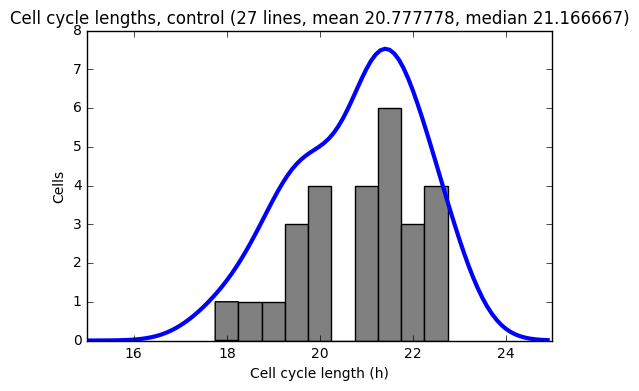

In [23]:
pt.hist(tim.TIME, color="gray")
pt.xlim(15, 25)
pt.title("Cell cycle lengths, control (%d lines, mean %f, median %f)" % (tim.index.size, np.mean(tim.TIME), np.median(tim.TIME)))
pt.ylabel("Cells")
pt.xlabel("Cell cycle length (h)")

## plot KDE
kde = stats.gaussian_kde(tim.TIME)
x = np.arange(15, 25, .1)
y = [v * tim.index.size for v in kde(x)]
pt.plot(x, y, 'b', linewidth=3)

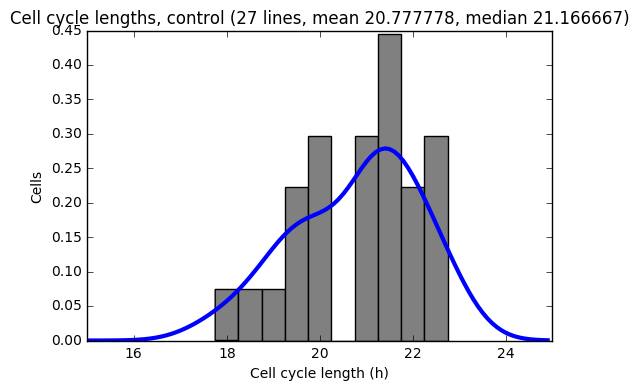

In [24]:
pt.hist(tim.TIME, color="gray", normed=True)
pt.xlim(15, 25)
pt.title("Cell cycle lengths, control (%d lines, mean %f, median %f)" % (tim.index.size, np.mean(tim.TIME), np.median(tim.TIME)))
pt.ylabel("Cells")
pt.xlabel("Cell cycle length (h)")

## plot KDE
kde = stats.gaussian_kde(tim.TIME)
x = np.arange(15, 25, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

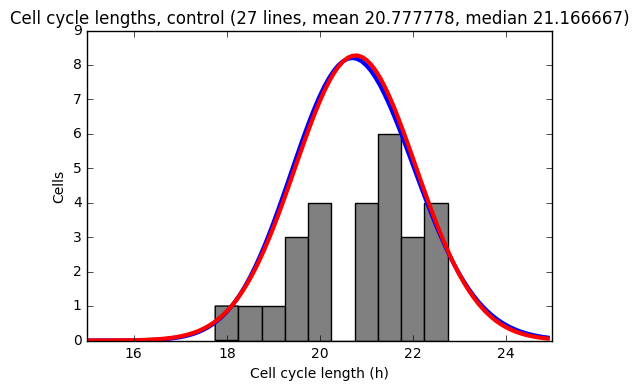

In [25]:
pt.hist(tim.TIME, color="gray")
pt.xlim(15, 25)
pt.title("Cell cycle lengths, control (%d lines, mean %f, median %f)" % (tim.index.size, np.mean(tim.TIME), np.median(tim.TIME)))
pt.ylabel("Cells")
pt.xlabel("Cell cycle length (h)")

## plot gamma
a, loc, b = gamma.fit(tim.TIME)
x = np.arange(15, 25, .1)
y = gamma.pdf(x, a, loc, b)
y = [val * tim.index.size for val in y]

pt.plot(x, y, label="gamma", c="b", linewidth=3)

## plot lognorm
shp, loc, scl = lognorm.fit(tim.TIME)
x = np.arange(15, 25, .1)
y = [v * tim.index.size for v in lognorm.pdf(x, shp, loc, scl)]
pt.plot(x, y, label="lognorm", c="r", linewidth=3)

## I.5 Create stats about PI information

In [26]:
## create reverse lookup for slit in PI video

slit_tree_map_ds = {}

for pos in dat_ds:
    slit_tree_map_ds[pos] = {}
    for tr in dat_ds[pos]['TREES']:
        slit_id = dat_ds[pos]['TREES'][tr]['SLIT_ID']
        if slit_id not in slit_tree_map_ds[pos]:
            slit_tree_map_ds[pos][slit_id] = [tr]
        else:
            slit_tree_map_ds[pos][slit_id].append(tr)

In [27]:
## create reverse lookup for slit in BF video

slit_tree_map_bf = {}

for pos in dat_f:
    slit_tree_map_bf[pos] = {}
    for tr in dat_f[pos]['TREES']:
        slit_id = dat_f[pos]['TREES'][tr]['SLIT_ID']
        if slit_id not in slit_tree_map_bf[pos]:
            slit_tree_map_bf[pos][slit_id] = [tr]
        else:
            slit_tree_map_bf[pos][slit_id].append(tr)

In [28]:
pos_counters = {}
for pos in slit_tree_map_ds.keys():
    pos_counters[pos] = 0
    for slit_id in slit_tree_map_ds[pos]:
        if slit_id in slit_tree_map_bf[pos]:
            pos_counters[pos] += 1

In [29]:
## create stats

positions = []
tracks = []
slit_with_tracks = []
slit_with_single_track = []
slit_with_single_track_match = []
slit_with_double_tracks = []
slit_with_double_tracks_match = []

for pos in slit_tree_map_ds.keys():
    positions.append(int(pos))
    slit_with_tracks.append(len(slit_tree_map_ds[pos]))
    
    trcks = 0
    swst = 0; swst_match = 0
    swdt = 0; swdt_match = 0
    
    for slit_id in slit_tree_map_ds[pos].keys():
        if len(slit_tree_map_ds[pos][slit_id]) == 1:
            swst += 1
            if slit_id in slit_tree_map_bf[pos]:
                swst_match += 1
        elif len(slit_tree_map_ds[pos][slit_id]) == 2:
            swdt += 1
            if slit_id in slit_tree_map_bf[pos]:
                swdt_match += 1
        trcks += len(slit_tree_map_ds[pos][slit_id])
     
    tracks.append(trcks)
    slit_with_single_track.append(swst)
    slit_with_single_track_match.append(swst_match)
    slit_with_double_tracks.append(swdt)
    slit_with_double_tracks_match.append(swdt_match)
    
stats_ds = pd.DataFrame({'POSITION': positions,
                         'Death-signal tracks': tracks,
                         'Slits with tracks': slit_with_tracks,
                         'Slits with single track': slit_with_single_track,
                         'Slits with single track in occupied slit in BF data': slit_with_single_track_match,
                        'Slits with two tracks': slit_with_double_tracks,
                        'Slits with two tracks in occupied slit in BF data': slit_with_double_tracks_match})

stats_ds = stats_ds[['POSITION', 'Death-signal tracks', 'Slits with tracks', 
                     'Slits with single track', 'Slits with single track in occupied slit in BF data',
                    'Slits with two tracks', 'Slits with two tracks in occupied slit in BF data']]

stats_ds = stats_ds.sort_values('POSITION')
stats_ds = stats_ds.reset_index(drop=True)

In [30]:
## DIFFERENT

stats_ds.to_csv('./stats_syn_ds.csv')

## I.5 Incorporate PI information to BF data

In [25]:
"""
Definition:
0 PI tracks: do nothig
1 PI tracks: use for Time-to-death analysis
2 PI tracks: use for TTD and correlation analysis
"""

'\nDefinition:\n0 PI tracks: do nothig\n1 PI tracks: use for Time-to-death analysis\n2 PI tracks: use for TTD and correlation analysis\n'

In [26]:
"""
Format for TTD analysis:
POSITION:
    List<Division_Time, Death_Time>
    
Format for Correlation analysis:
POSITION:
    List<Division_Time, Death_Time_1, Death_Time_2>
"""

'\nFormat for TTD analysis:\nPOSITION:\n    List<Division_Time, Death_Time>\n    \nFormat for Correlation analysis:\nPOSITION:\n    List<Division_Time, Death_Time_1, Death_Time_2>\n'

In [31]:
## DIFFERENT

correlation_analysis = {}
ttd_analysis = {}
ttd_analysis_double = {}

for pos in slit_tree_map_ds.keys():
    correlation_analysis[pos] = []
    ttd_analysis[pos] = []
    ttd_analysis_double[pos] = []
    for slit_id in slit_tree_map_ds[pos]:
        if slit_id in slit_tree_map_bf[pos]:
            
            ## double track == TTD and correlation
            if len(slit_tree_map_ds[pos][slit_id]) == 2:
                
                # extract div time from BF tree
                tr = slit_tree_map_bf[pos][slit_id][0]
#                 tr_div_time = dat_fat[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                tr_div_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                
                # extract death time from DS tree I and II
                tr_ds_1 = slit_tree_map_ds[pos][slit_id][0]
                tr_ds_2 = slit_tree_map_ds[pos][slit_id][1]
                tr_death_time_1 = dat_ds[pos]['TREES'][tr_ds_1]['POSITION_T'][tr_ds_1][1]
                tr_death_time_2 = dat_ds[pos]['TREES'][tr_ds_2]['POSITION_T'][tr_ds_2][1]
                correlation_analysis[pos].append((tr_death_time_1, tr_death_time_2))
                ttd_analysis[pos].append(tr_death_time_1)
                ttd_analysis[pos].append(tr_death_time_2)
                ttd_analysis_double[pos].append(tr_death_time_1)
                ttd_analysis_double[pos].append(tr_death_time_2)
                
            elif len(slit_tree_map_ds[pos][slit_id]) == 1:
                
                # extract div time from BF tree
                tr = slit_tree_map_bf[pos][slit_id][0]
#                 tr_div_time = dat_fat[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                tr_div_time = dat_f[pos]['TREES'][tr]['POSITION_T'][tr][-1]
                
                # extract death time from DS tree
                tr_ds = slit_tree_map_ds[pos][slit_id][0]
                tr_death_time = dat_ds[pos]['TREES'][tr_ds]['POSITION_T'][tr_ds][1]
                
                ttd_analysis[pos].append(tr_death_time)

pearson's corr, p-val = (0.048694421626248083, 0.58368888706998745)


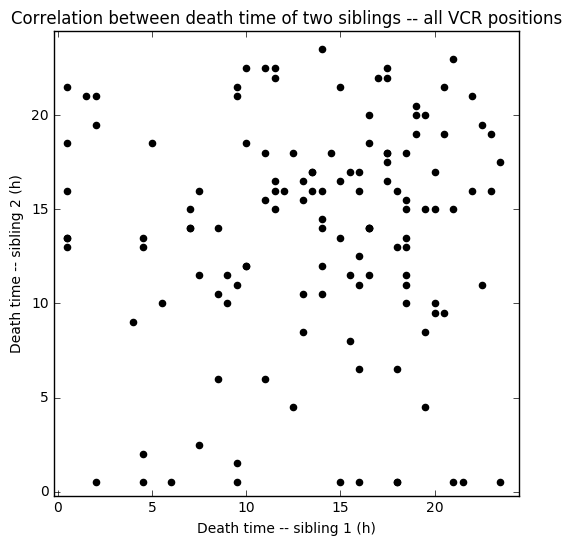

In [34]:
## DIFFERENT

deathtime1 = []
deathtime2 = []
positions = []

for pos in set(ttd_analysis.keys()) - dauno_positions:
    deathtime1_pos = [p[0] for p in correlation_analysis[pos]]
    deathtime2_pos = [p[1] for p in correlation_analysis[pos]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos
    positions += ([pos] * len(deathtime1_pos))


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("Correlation between death time of two siblings -- all VCR positions")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(6, 6)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pt.savefig('D:/Dropbox/Edu/MA/20171022_results/images/syn/corr_all.pdf')

pd.DataFrame({"SISTER_1": deathtime1, "SISTER_2": deathtime2, "POSITION": positions}).to_csv('../results/syn_sister_death_corr.csv')

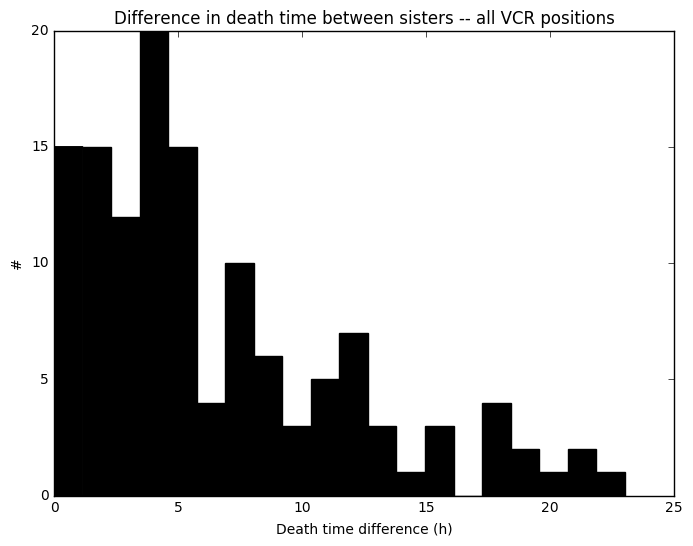

In [35]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in set(ttd_analysis.keys()) - dauno_positions:
    deathtime1_pos = [p[0] for p in correlation_analysis[pos]]
    deathtime2_pos = [p[1] for p in correlation_analysis[pos]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos
    
deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
deathtime_diff = np.abs(np.array(deathtime1) - np.array(deathtime2))

pt.hist(deathtime_diff, bins=20, color="black")

pt.title("Difference in death time between sisters -- all VCR positions")
pt.xlabel("Death time difference (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(8, 6)

pearson's corr, p-val = (0.14848382732052234, 0.33608877043433649)


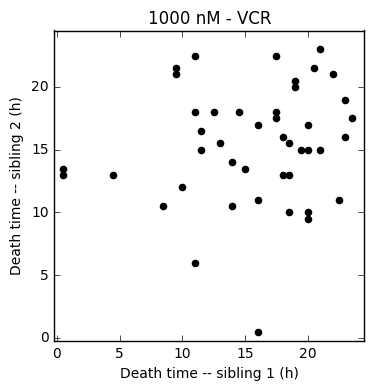

In [36]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(9))[1:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("1000 nM - VCR")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (0.48524698136670624, 0.066727021019196128)


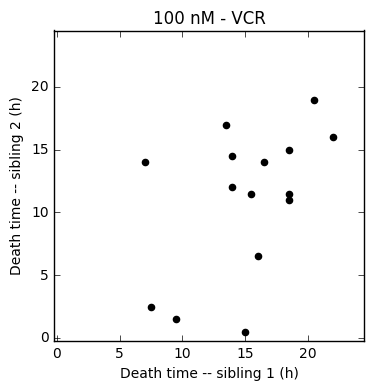

In [37]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(16))[9:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("100 nM - VCR")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (-0.30356877636561863, 0.27136023385184177)


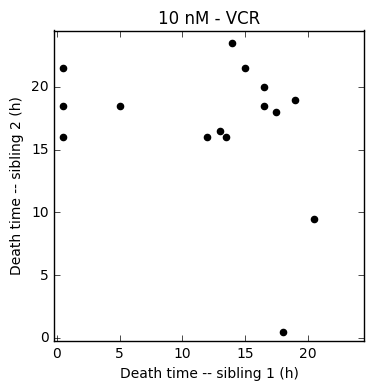

In [38]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(24))[16:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("10 nM - VCR")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (-0.21840586018701044, 0.45317193202228734)


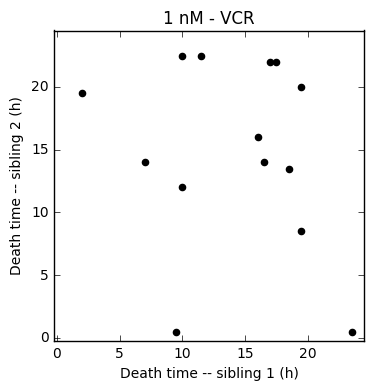

In [39]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(32))[24:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("1 nM - VCR")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (0.36102339878347456, 0.33980061430326397)


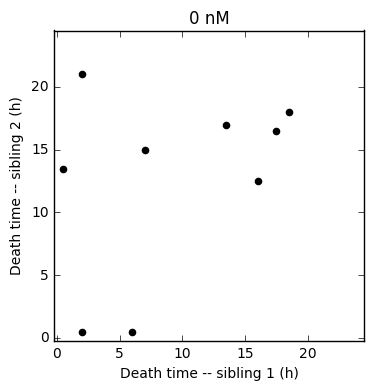

In [40]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(40))[32:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("0 nM")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (-0.49114647029057834, 0.21647896339548556)


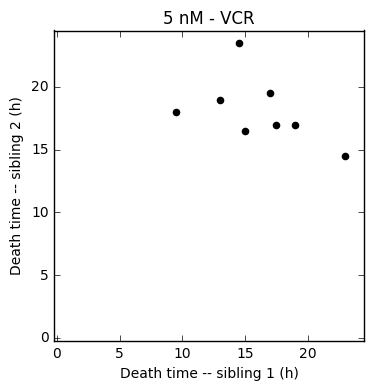

In [41]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(48))[40:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("5 nM - VCR")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (0.4333960439478094, 0.46598055609127065)


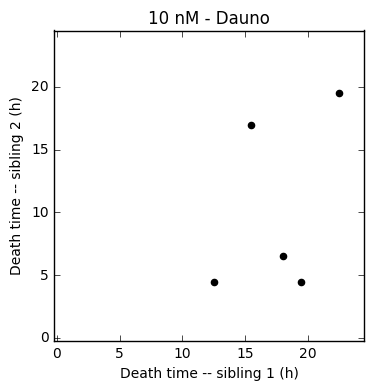

In [42]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(55))[48:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("10 nM - Dauno")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

pearson's corr, p-val = (-0.2724043619237092, 0.16924392360543195)


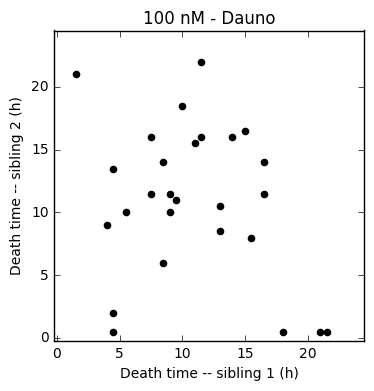

In [43]:
## DIFFERENT

deathtime1 = []
deathtime2 = []

for pos in list(set(list(range(64))[55:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime1_pos = [p[0] for p in correlation_analysis[stringify_position(pos)]]
    deathtime2_pos = [p[1] for p in correlation_analysis[stringify_position(pos)]]
    
    deathtime1 += deathtime1_pos
    deathtime2 += deathtime2_pos


deathtime1 = [t / 3600. for t in deathtime1]
deathtime2 = [t / 3600. for t in deathtime2]
pt.scatter(deathtime1, deathtime2, c='black')
pt.xlim(-0.2, 24.5)
pt.ylim (-0.2, 24.5)
pt.title("100 nM - Dauno")
pt.xlabel("Death time -- sibling 1 (h)")
pt.ylabel("Death time -- sibling 2 (h)")
# pt.axhline(21, c='r')
# pt.axvline(21, c='r')
pt.gcf().set_size_inches(4, 4)
print("pearson's corr, p-val = " + str(pearsonr(deathtime1, deathtime2)))

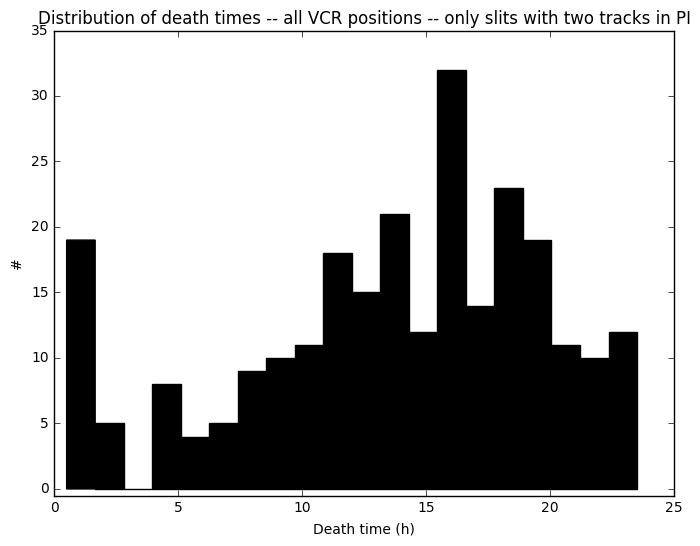

In [44]:
## DIFFERENT

deathtime = []

for pos in set(ttd_analysis.keys()) - dauno_positions:
    deathtime += ttd_analysis_double[pos]

deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("Distribution of death times -- all VCR positions -- only slits with two tracks in PI")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(8, 6)
pt.ylim(-0.5, 35)

pd.Series(deathtime).to_csv("./syn_dt_syn_2_children.csv")

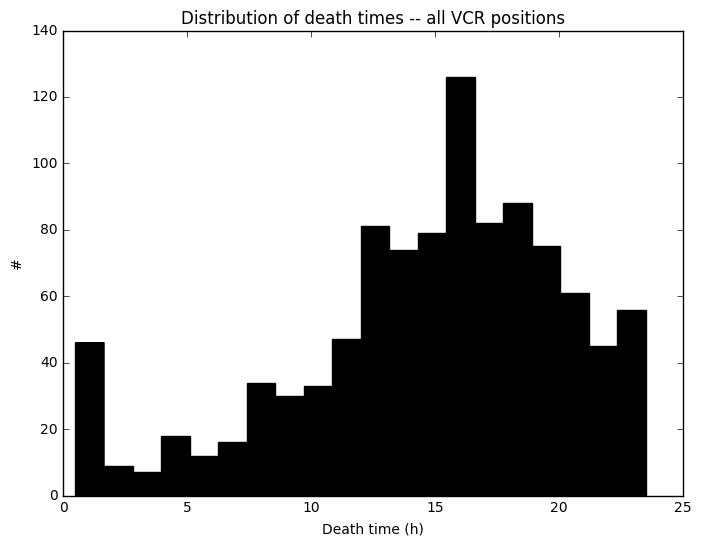

In [45]:
## DIFFERENT

deathtime = []

for pos in set(ttd_analysis.keys()) - dauno_positions:
    deathtime += ttd_analysis[pos]

deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("Distribution of death times -- all VCR positions")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(8, 6)

pd.Series(deathtime).to_csv("./syn_dt_syn_all.csv")

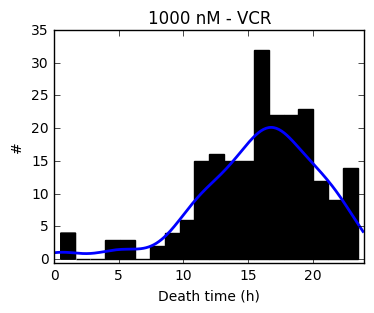

In [46]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(9))[1:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("1000 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=2)

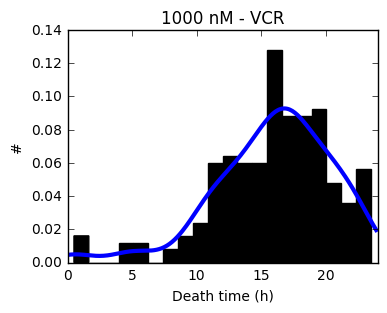

In [47]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(9))[1:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("1000 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

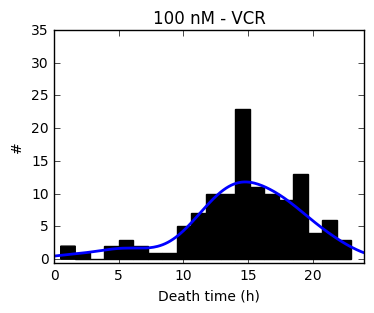

In [48]:
## DIFFERENT

divtime = []
deathtime = []

for pos in list(set(list(range(16))[9:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("100 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=2)

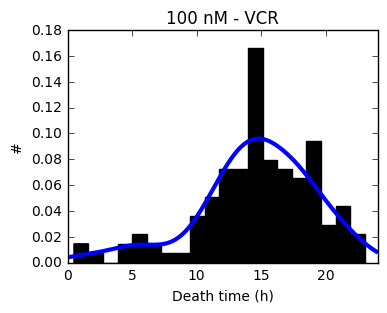

In [49]:
## DIFFERENT

divtime = []
deathtime = []

for pos in list(set(list(range(16))[9:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("100 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

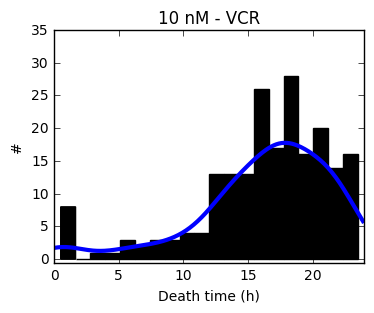

In [50]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(24))[16:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("10 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=3)

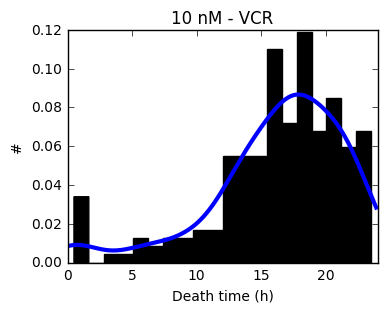

In [51]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(24))[16:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("10 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

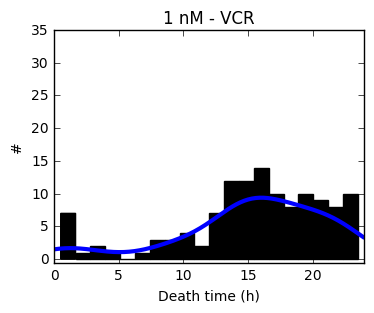

In [52]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(32))[24:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("1 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=3)

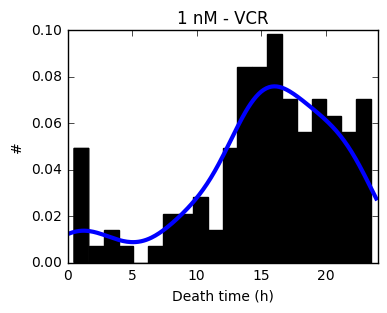

In [53]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(32))[24:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("1 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

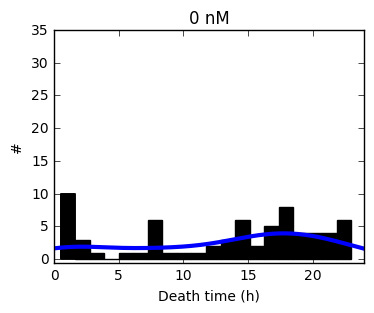

In [54]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(40))[32:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("0 nM")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=3)

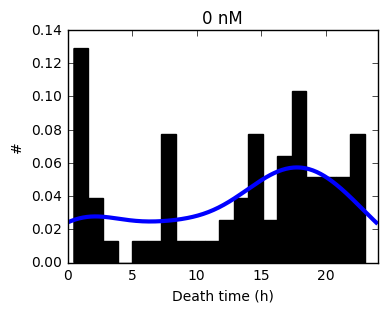

In [55]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(40))[32:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("0 nM")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

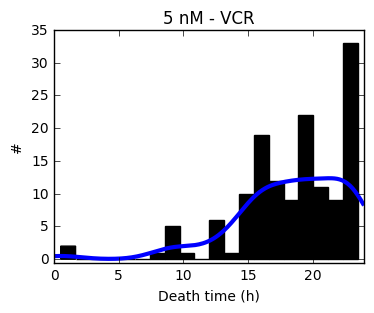

In [56]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(48))[40:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("5 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=3)

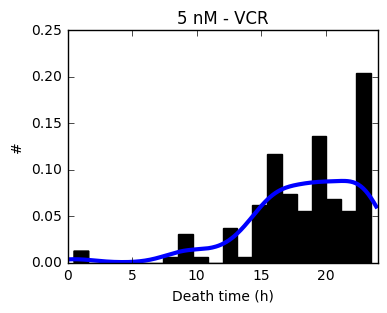

In [57]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(48))[40:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("5 nM - VCR")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

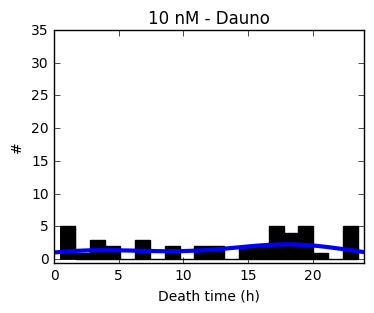

In [58]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(55))[48:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("10 nM - Dauno")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=3)

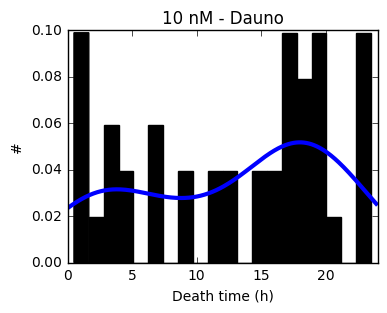

In [59]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(55))[48:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("10 nM - Dauno")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)

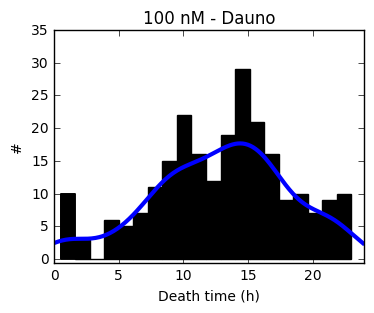

In [60]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(64))[55:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black")
pt.title("100 nM - Dauno")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.ylim(-0.5, 35)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
y = kde(x)
y = [val * len(deathtime) for val in y]
pt.plot(x, y, 'b', linewidth=3)

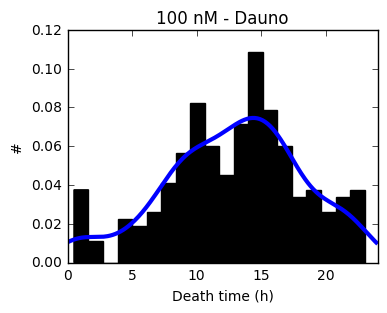

In [61]:
## DIFFERENT

deathtime = []

for pos in list(set(list(range(64))[55:]) - set([4, 5, 10, 12, 14, 19, 20, 25, 26, 29, 34, 37, 38, 44, 47, 50, 53, 59, 60])):
    deathtime += ttd_analysis[stringify_position(pos)]
    
deathtime = [t / 3600. for t in deathtime]
pt.hist(deathtime, bins=20, color="black", normed=True)
pt.title("100 nM - Dauno")
pt.xlabel("Death time (h)")
pt.ylabel("#")
pt.gcf().set_size_inches(4, 3)
pt.xlim(0,24)

## plot KDE
kde = stats.gaussian_kde(deathtime)
x = np.arange(0, 24, .1)
pt.plot(x, kde(x), 'b', linewidth=3)